# Project 2 - Classification

For this project, I am going to build classification models to predict if a person is diabetic or not given certain features. My main goal for this project is to understand various classification algorithms on a deeper level and be able to compare them.

## Inspecting the data


In [1]:
# import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import scipy.stats as stats


In [2]:
# read data
data = pd.read_csv('/content/diabetes_binary_5050split_health_indicators_BRFSS2015.csv')

In [3]:
# inspect shape, columns, nulls, datatypes
data.shape

(70692, 22)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70692 entries, 0 to 70691
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Diabetes_binary       70692 non-null  float64
 1   HighBP                70692 non-null  float64
 2   HighChol              70692 non-null  float64
 3   CholCheck             70692 non-null  float64
 4   BMI                   70692 non-null  float64
 5   Smoker                70692 non-null  float64
 6   Stroke                70692 non-null  float64
 7   HeartDiseaseorAttack  70692 non-null  float64
 8   PhysActivity          70692 non-null  float64
 9   Fruits                70692 non-null  float64
 10  Veggies               70692 non-null  float64
 11  HvyAlcoholConsump     70692 non-null  float64
 12  AnyHealthcare         70692 non-null  float64
 13  NoDocbcCost           70692 non-null  float64
 14  GenHlth               70692 non-null  float64
 15  MentHlth           

There are no nulls so that is great.

In [5]:
data.head()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,3.0,5.0,30.0,0.0,1.0,4.0,6.0,8.0
1,0.0,1.0,1.0,1.0,26.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,1.0,12.0,6.0,8.0
2,0.0,0.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,10.0,0.0,1.0,13.0,6.0,8.0
3,0.0,1.0,1.0,1.0,28.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,3.0,0.0,3.0,0.0,1.0,11.0,6.0,8.0
4,0.0,0.0,0.0,1.0,29.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,8.0,5.0,8.0


After inpsecting the data, I see that there are 2 types of variables in the dataset: categorical and numerical variables. So, instead of calculating correlation normally, I will need to use Cramer's V to calculate the correlation between each of the categorical value with the target and point biserial between the numerical value with the target.

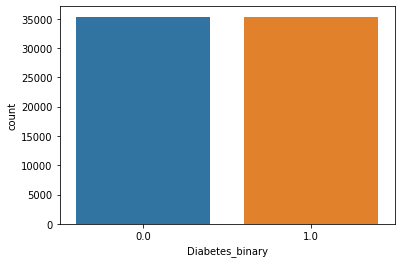

In [6]:
# Check see if data is balanced
ax = sns.countplot(x="Diabetes_binary", data=data)

In [7]:
data['Diabetes_binary'].value_counts()

0.0    35346
1.0    35346
Name: Diabetes_binary, dtype: int64

Data is perfectly balanced.


## Preprocessing - Calculating Correlation

First, I will calculate the correlation between numerical data and categorical data using Point Biserial. A result of 1 means there is a positive correlation, 0 means there is no correlation, and -1 means there is a negative correlation.

In [8]:
# calculate point-biserial correlation between BMI and target
x = data['Diabetes_binary'].to_numpy()
y = data['BMI'].to_numpy()
stats.pointbiserialr(x, y)

PointbiserialrResult(correlation=0.29337274476104624, pvalue=0.0)

In [9]:
# similarly, correlation between target and mental health days
x = data['Diabetes_binary'].to_numpy()
y = data['MentHlth'].to_numpy()
stats.pointbiserialr(x, y)

PointbiserialrResult(correlation=0.08702877147509541, pvalue=6.795439709628024e-119)

In [10]:
# correlation between target and days with physical illness or injury
x = data['Diabetes_binary'].to_numpy()
y = data['PhysHlth'].to_numpy()
stats.pointbiserialr(x, y)

PointbiserialrResult(correlation=0.21308101903810778, pvalue=0.0)

Since the p-value of all 3 correlations are less than .05, they are statistically significant. 

Now I will use Cramer's V to calculate correlation between the categorical variables. A result of 1 means highly associated, 0 means not.

In [11]:
# define cramers_v function
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [12]:
# New dataframe with only categorical values
data2 = data.copy()
data2 = data2.drop(columns=['BMI', 'MentHlth', 'PhysHlth'])
data2

,Diabetes_binary,HighBP,HighChol,CholCheck,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,3.0,0.0,1.0,4.0,6.0,8.0
1,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,3.0,0.0,1.0,12.0,6.0,8.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,13.0,6.0,8.0
3,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,3.0,0.0,1.0,11.0,6.0,8.0
4,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,8.0,5.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70687,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,4.0,0.0,0.0,6.0,4.0,1.0
70688,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,2.0,1.0,1.0,10.0,3.0,6.0
70689,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,5.0,1.0,0.0,13.0,6.0,4.0
70690,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,1.0,0.0,11.0,2.0,4.0


In [13]:
# Make empty dataframe
df_cramers = pd.DataFrame(index = data2.columns, columns = data2.columns)
# Use the function above to calculate cramers_v
for col in df_cramers.columns:
    for row in df_cramers.index:
        df_cramers[col][row] = cramers_v(data2[col], data2[row])

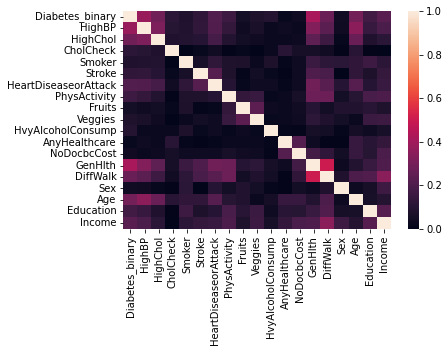

In [14]:
# Visualize it
sns.heatmap(df_cramers.astype(float))

In [15]:
df_cramers

,Diabetes_binary,HighBP,HighChol,CholCheck,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,DiffWalk,Sex,Age,Education,Income
Diabetes_binary,0.999972,0.381471,0.289162,0.11523,0.085889,0.125313,0.211452,0.158591,0.053917,0.07917,0.094709,0.022815,0.040755,0.417135,0.272589,0.044225,0.295364,0.173472,0.233325
HighBP,0.381471,0.999971,0.316466,0.103124,0.087329,0.128947,0.210678,0.13602,0.04065,0.066483,0.026696,0.035497,0.0262,0.328611,0.234723,0.040617,0.34953,0.144578,0.198216
HighChol,0.289162,0.316466,0.999972,0.085808,0.093295,0.099657,0.181109,0.090345,0.047205,0.042636,0.025093,0.031238,0.032937,0.24258,0.161968,0.016882,0.271031,0.084759,0.111766
CholCheck,0.11523,0.103124,0.085808,0.999707,0.001956,0.022022,0.043206,0.00723,0.016876,0.0,0.026657,0.106515,0.0624,0.061656,0.044166,0.006947,0.108023,0.007366,0.0
Smoker,0.085889,0.087329,0.093295,0.001956,0.999972,0.064491,0.124322,0.079704,0.074688,0.029654,0.077675,0.012309,0.035552,0.152524,0.119698,0.112034,0.126877,0.164007,0.115921
Stroke,0.125313,0.128947,0.099657,0.022022,0.064491,0.999879,0.223281,0.079833,0.008106,0.047381,0.022944,0.005107,0.035902,0.203748,0.192163,0.000128,0.125096,0.076245,0.137563
HeartDiseaseorAttack,0.211452,0.210678,0.181109,0.043206,0.124322,0.223281,0.999944,0.098108,0.019027,0.036071,0.03684,0.015131,0.035763,0.287309,0.232536,0.09805,0.225598,0.097944,0.149964
PhysActivity,0.158591,0.13602,0.090345,0.00723,0.079704,0.079833,0.098108,0.999966,0.133729,0.149238,0.018659,0.026751,0.063137,0.277149,0.276809,0.051585,0.104097,0.194184,0.202555
Fruits,0.053917,0.04065,0.047205,0.016876,0.074688,0.008106,0.019027,0.133729,0.99997,0.238542,0.03296,0.029073,0.045638,0.099937,0.050612,0.088615,0.086784,0.105919,0.080944
Veggies,0.07917,0.066483,0.042636,0.0,0.029654,0.047381,0.036071,0.149238,0.238542,0.999958,0.021681,0.028825,0.036896,0.117293,0.083948,0.052435,0.025875,0.154883,0.156458


I will drop several variables that have very low correlation with the target: Smoker, Fruits, Veggies, HvyAlcoholConsump, AnyHealthcare, NoDocbcCost, Sex as Cramer V's values below 0.1 indicate no to very weak relationship. This also helps with the model's performance.

In [16]:
data = data.drop(columns=['Smoker', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'Sex'])

In [17]:
data

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Stroke,HeartDiseaseorAttack,PhysActivity,GenHlth,MentHlth,PhysHlth,DiffWalk,Age,Education,Income
0,0.0,1.0,0.0,1.0,26.0,0.0,0.0,1.0,3.0,5.0,30.0,0.0,4.0,6.0,8.0
1,0.0,1.0,1.0,1.0,26.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,12.0,6.0,8.0
2,0.0,0.0,0.0,1.0,26.0,0.0,0.0,1.0,1.0,0.0,10.0,0.0,13.0,6.0,8.0
3,0.0,1.0,1.0,1.0,28.0,0.0,0.0,1.0,3.0,0.0,3.0,0.0,11.0,6.0,8.0
4,0.0,0.0,0.0,1.0,29.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,8.0,5.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70687,1.0,0.0,1.0,1.0,37.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,6.0,4.0,1.0
70688,1.0,0.0,1.0,1.0,29.0,0.0,1.0,0.0,2.0,0.0,0.0,1.0,10.0,3.0,6.0
70689,1.0,1.0,1.0,1.0,25.0,0.0,1.0,0.0,5.0,15.0,0.0,1.0,13.0,6.0,4.0
70690,1.0,1.0,1.0,1.0,18.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,11.0,2.0,4.0


## Data Understanding

I am going to visualize each feature's count of each Diabetes status category. 

   Diabetes_binary  HighBP  Count
0              0.0     0.0  22118
1              0.0     1.0  13228
2              1.0     0.0   8742
3              1.0     1.0  26604


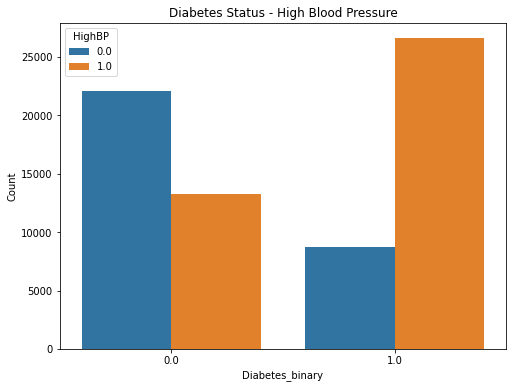

In [18]:
# group Diabetes_binary & HighBP
diabetes_bp = data.groupby(['Diabetes_binary', 'HighBP']).size().reset_index(name = 'Count')
print(diabetes_bp)
# visualize 
plt.figure(figsize = (8,6))
sns.barplot(x = 'Diabetes_binary', y = 'Count', hue = 'HighBP', data = diabetes_bp)
plt.title("Diabetes Status - High Blood Pressure")
plt.show()

   Diabetes_binary  HighChol  Count
0              0.0       0.0  21869
1              0.0       1.0  13477
2              1.0       0.0  11660
3              1.0       1.0  23686


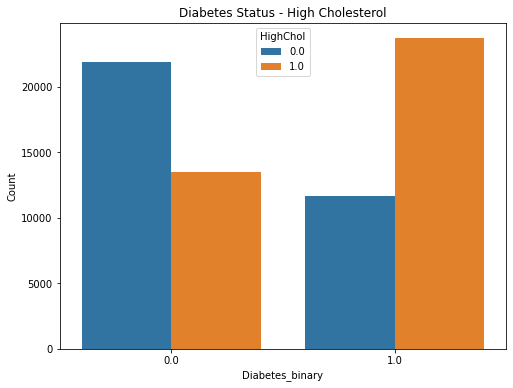

In [19]:
# group Diabetes_binary & HighChol
diabetes_hc = data.groupby(['Diabetes_binary', 'HighChol']).size().reset_index(name = 'Count')
print(diabetes_hc)
# visualize 
plt.figure(figsize = (8,6))
sns.barplot(x = 'Diabetes_binary', y = 'Count', hue = 'HighChol', data = diabetes_hc)
plt.title("Diabetes Status - High Cholesterol")
plt.show()

   Diabetes_binary  CholCheck  Count
0              0.0        0.0   1508
1              0.0        1.0  33838
2              1.0        0.0    241
3              1.0        1.0  35105


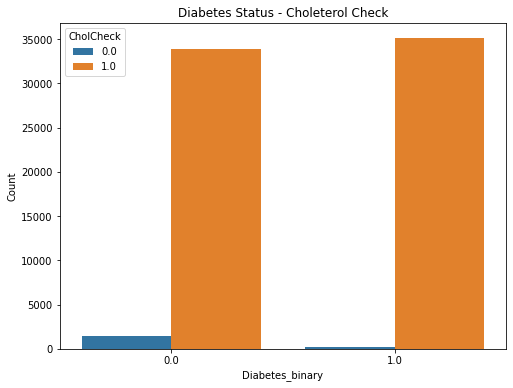

In [20]:
# group Diabetes_binary & CholCheck
diabetes_cc = data.groupby(['Diabetes_binary', 'CholCheck']).size().reset_index(name = 'Count')
print(diabetes_cc)
# visualize
plt.figure(figsize = (8,6))
sns.barplot(x = 'Diabetes_binary', y = 'Count', hue = 'CholCheck', data = diabetes_cc)
plt.title("Diabetes Status - Choleterol Check")
plt.show()

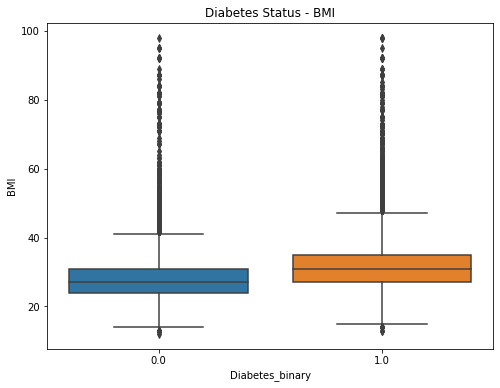

In [21]:
# visualize diabetes status ~ BMI
plt.figure(figsize = (8,6))
sns.boxplot(data = data, x = 'Diabetes_binary', y = 'BMI')
plt.title("Diabetes Status - BMI")
plt.show()

   Diabetes_binary  Stroke  Count
0              0.0     0.0  34219
1              0.0     1.0   1127
2              1.0     0.0  32078
3              1.0     1.0   3268


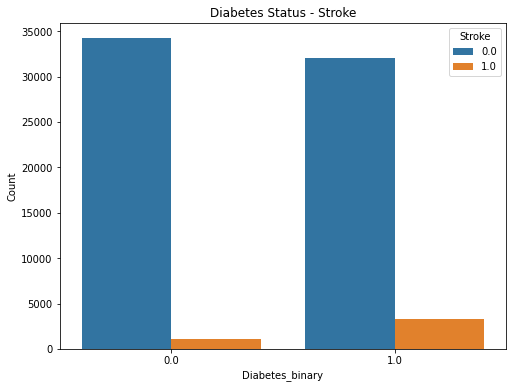

In [22]:
# group Diabetes_binary & Stroke
diabetes_st = data.groupby(['Diabetes_binary', 'Stroke']).size().reset_index(name = 'Count')
print(diabetes_st)
# visualize
plt.figure(figsize = (8,6))
sns.barplot(x = 'Diabetes_binary', y = 'Count', hue = 'Stroke', data = diabetes_st)
plt.title("Diabetes Status - Stroke")
plt.show()

   Diabetes_binary  HeartDiseaseorAttack  Count
0              0.0                   0.0  32775
1              0.0                   1.0   2571
2              1.0                   0.0  27468
3              1.0                   1.0   7878


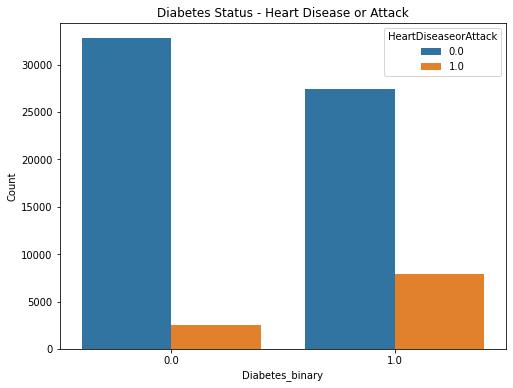

In [23]:
# group Diabetes_binary & HeartDiseaseorAttack
diabetes_hd = data.groupby(['Diabetes_binary', 'HeartDiseaseorAttack']).size().reset_index(name = 'Count')
print(diabetes_hd)
# visualize
plt.figure(figsize = (8,6))
sns.barplot(x = 'Diabetes_binary', y = 'Count', hue = 'HeartDiseaseorAttack', data = diabetes_hd)
plt.title("Diabetes Status - Heart Disease or Attack")
plt.show()

   Diabetes_binary  PhysActivity  Count
0              0.0           0.0   7934
1              0.0           1.0  27412
2              1.0           0.0  13059
3              1.0           1.0  22287


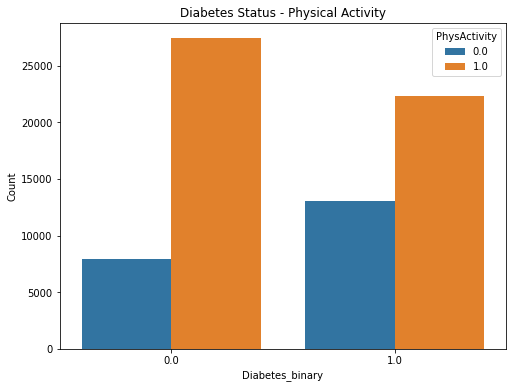

In [24]:
# group Diabetes_binary & PhysActivity
diabetes_pa = data.groupby(['Diabetes_binary', 'PhysActivity']).size().reset_index(name = 'Count')
print(diabetes_pa)
# visualize
plt.figure(figsize = (8,6))
sns.barplot(x = 'Diabetes_binary', y = 'Count', hue = 'PhysActivity', data = diabetes_pa)
plt.title("Diabetes Status - Physical Activity")
plt.show()

   Diabetes_binary  GenHlth  Count
0              0.0      1.0   7142
1              0.0      2.0  13491
2              0.0      3.0   9970
3              0.0      4.0   3513
4              0.0      5.0   1230
5              1.0      1.0   1140
6              1.0      2.0   6381
7              1.0      3.0  13457
8              1.0      4.0   9790
9              1.0      5.0   4578


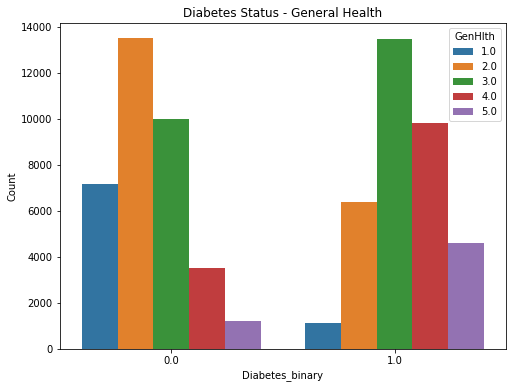

In [25]:
# group diabetes status & GenHlth
diabetes_general = data.groupby(['Diabetes_binary', 'GenHlth']).size().reset_index(name = 'Count')
print(diabetes_general)
# visualize diabetes status - GenHlth
plt.figure(figsize = (8,6))
sns.barplot(x = 'Diabetes_binary', y = 'Count', hue = 'GenHlth', data = diabetes_general)
plt.title("Diabetes Status - General Health")
plt.show()

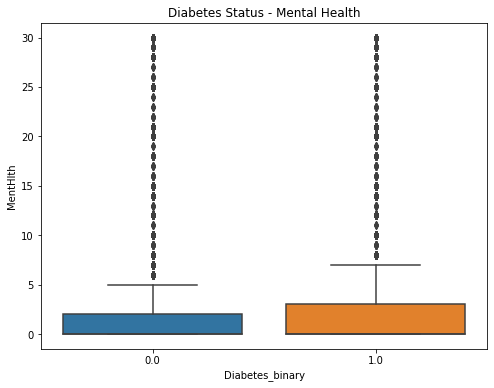

In [26]:
# visualize Diabetes_binary - MentHlth
plt.figure(figsize = (8,6))
sns.boxplot(data = data, x = 'Diabetes_binary', y = 'MentHlth')
plt.title("Diabetes Status - Mental Health")
plt.show()

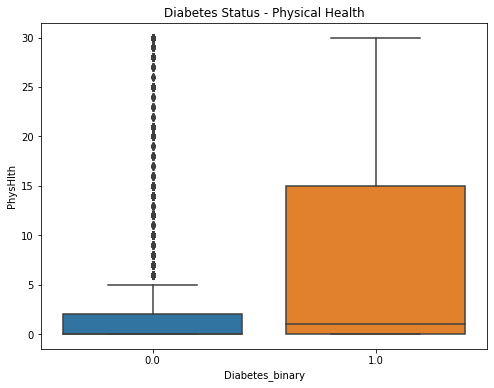

In [27]:
# visualize Diabetes_binary - PhysHlth
plt.figure(figsize = (8,6))
sns.boxplot(data = data, x = 'Diabetes_binary', y = 'PhysHlth')
plt.title("Diabetes Status - Physical Health")
plt.show()

   Diabetes_binary  DiffWalk  Count
0              0.0       0.0  30601
1              0.0       1.0   4745
2              1.0       0.0  22225
3              1.0       1.0  13121


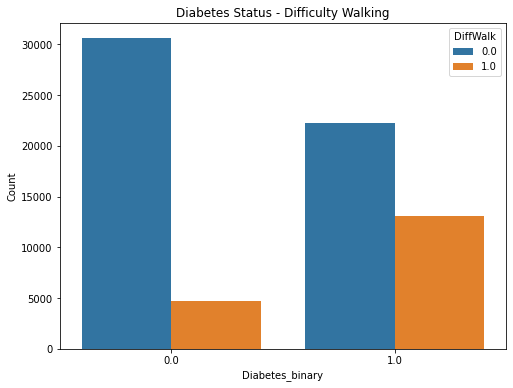

In [28]:
# group diabetes status & DiffWalk
diabetes_dw = data.groupby(['Diabetes_binary', 'DiffWalk']).size().reset_index(name = 'Count')
print(diabetes_dw)
# visualize diabetes status - GenHlth
plt.figure(figsize = (8,6))
sns.barplot(x = 'Diabetes_binary', y = 'Count', hue = 'DiffWalk', data = diabetes_dw)
plt.title("Diabetes Status - Difficulty Walking")
plt.show()

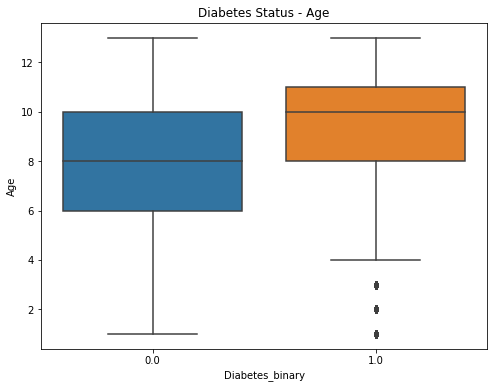

In [29]:
# visualize diabetes status - age
plt.figure(figsize = (8,6))
sns.boxplot(data = data, x = 'Diabetes_binary', y = 'Age')
plt.title("Diabetes Status - Age")
plt.show()

    Diabetes_binary  Education  Count
0               0.0        1.0     28
1               0.0        2.0    464
2               0.0        3.0   1151
3               0.0        4.0   8407
4               0.0        5.0   9676
5               0.0        6.0  15620
6               1.0        1.0     47
7               1.0        2.0   1183
8               1.0        3.0   2296
9               1.0        4.0  11066
10              1.0        5.0  10354
11              1.0        6.0  10400


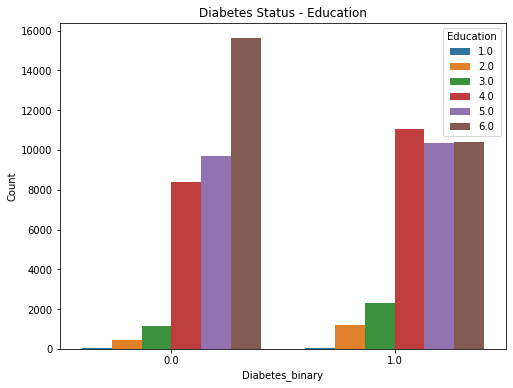

In [30]:
# group diabetes status & education
diabetes_ed = data.groupby(['Diabetes_binary', 'Education']).size().reset_index(name = 'Count')
print(diabetes_ed)
# visualize diabetes status ~ education
plt.figure(figsize = (8,6))
sns.barplot(x = 'Diabetes_binary', y = 'Count', hue = 'Education', data = diabetes_ed)
plt.title("Diabetes Status - Education")
plt.show()

    Diabetes_binary  Income  Count
0               0.0     1.0   1228
1               0.0     2.0   1412
2               0.0     3.0   1989
3               0.0     4.0   2604
4               0.0     5.0   3506
5               0.0     6.0   4996
6               0.0     7.0   6160
7               0.0     8.0  13451
8               1.0     1.0   2383
9               1.0     2.0   3086
10              1.0     3.0   3568
11              1.0     4.0   4054
12              1.0     5.0   4504
13              1.0     6.0   5291
14              1.0     7.0   5265
15              1.0     8.0   7195


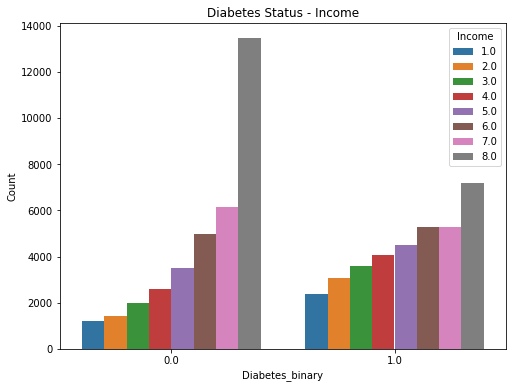

In [31]:
#group diabetes status & income
diabetes_income = data.groupby(['Diabetes_binary', 'Income']).size().reset_index(name = 'Count')
print(diabetes_income)
#visualize diabetes status ~ income
plt.figure(figsize = (8,6))
sns.barplot(x = 'Diabetes_binary', y = 'Count', hue = 'Income', data = diabetes_income)
plt.title("Diabetes Status - Income")
plt.show()

## Modeling & Evaluating Results

### 1. Naive Bayes

I am going to start with Naive Bayes because this is a fairly simple technique to use and it works well with a large data set. Based on Bayes' Theorem, this method assumes that the variables are independent of each other.
Because my data set has a mix of numerical and categorical data, I will need to preprocess the data by converting the continuous variables (BMI, MentHlth, PhysHlth) into bins. I am going to use Categorical NB for this as it assumes that the data has categorical distribution and each category is encoded ordinally.

In [32]:
# import sklearn Naive Bayes package
from sklearn.naive_bayes import CategoricalNB

In [33]:
# make a copy of the original dataframe
data3 = data.copy()
data3

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Stroke,HeartDiseaseorAttack,PhysActivity,GenHlth,MentHlth,PhysHlth,DiffWalk,Age,Education,Income
0,0.0,1.0,0.0,1.0,26.0,0.0,0.0,1.0,3.0,5.0,30.0,0.0,4.0,6.0,8.0
1,0.0,1.0,1.0,1.0,26.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,12.0,6.0,8.0
2,0.0,0.0,0.0,1.0,26.0,0.0,0.0,1.0,1.0,0.0,10.0,0.0,13.0,6.0,8.0
3,0.0,1.0,1.0,1.0,28.0,0.0,0.0,1.0,3.0,0.0,3.0,0.0,11.0,6.0,8.0
4,0.0,0.0,0.0,1.0,29.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,8.0,5.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70687,1.0,0.0,1.0,1.0,37.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,6.0,4.0,1.0
70688,1.0,0.0,1.0,1.0,29.0,0.0,1.0,0.0,2.0,0.0,0.0,1.0,10.0,3.0,6.0
70689,1.0,1.0,1.0,1.0,25.0,0.0,1.0,0.0,5.0,15.0,0.0,1.0,13.0,6.0,4.0
70690,1.0,1.0,1.0,1.0,18.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,11.0,2.0,4.0


In [34]:
# Put continuous variables into bins of 20% quantiles
names = ['bottom 20', 'lower 20', 'middle 20', 'upper 20', 'top 20']
data3['BMI_qt'] = pd.cut(data3['BMI'].rank(pct=True), bins=5, labels=names)
data3['MentHlth_qt'] = pd.cut(data3['MentHlth'].rank(pct=True), bins=5, labels=names)
data3['PhysHlth_qt'] = pd.cut(data3['PhysHlth'].rank(pct=True), bins=5, labels=names)
# drop original columns from the data
data3 = data3.drop(columns=['BMI', 'MentHlth', 'PhysHlth'])

In [35]:
data3

,Diabetes_binary,HighBP,HighChol,CholCheck,Stroke,HeartDiseaseorAttack,PhysActivity,GenHlth,DiffWalk,Age,Education,Income,BMI_qt,MentHlth_qt,PhysHlth_qt
0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,3.0,0.0,4.0,6.0,8.0,lower 20,upper 20,top 20
1,0.0,1.0,1.0,1.0,1.0,0.0,0.0,3.0,0.0,12.0,6.0,8.0,lower 20,bottom 20,bottom 20
2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,13.0,6.0,8.0,lower 20,bottom 20,upper 20
3,0.0,1.0,1.0,1.0,0.0,0.0,1.0,3.0,0.0,11.0,6.0,8.0,middle 20,bottom 20,upper 20
4,0.0,0.0,0.0,1.0,0.0,0.0,1.0,2.0,0.0,8.0,5.0,8.0,middle 20,bottom 20,bottom 20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70687,1.0,0.0,1.0,1.0,0.0,0.0,0.0,4.0,0.0,6.0,4.0,1.0,top 20,bottom 20,bottom 20
70688,1.0,0.0,1.0,1.0,0.0,1.0,0.0,2.0,1.0,10.0,3.0,6.0,middle 20,bottom 20,bottom 20
70689,1.0,1.0,1.0,1.0,0.0,1.0,0.0,5.0,1.0,13.0,6.0,4.0,lower 20,top 20,bottom 20
70690,1.0,1.0,1.0,1.0,0.0,0.0,0.0,4.0,1.0,11.0,2.0,4.0,bottom 20,bottom 20,bottom 20


In [36]:
# drop target from X and save target to y
X = data3.drop('Diabetes_binary', axis = 1)
y = data3['Diabetes_binary']

In [37]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split

In [38]:
# encode categorical variables
enc = OrdinalEncoder()
X = enc.fit_transform(X)
# create training and testing samples
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [39]:
# build a Categorical Classifier
cnb = CategoricalNB()
# train the model 
%time cnb.fit(X_train, y_train)
# mean accuracy 
cnb.score(X_test, y_test)

CPU times: user 51.2 ms, sys: 4.01 ms, total: 55.2 ms
Wall time: 73.9 ms


0.738666100855789

In [40]:
# get the predictions
y_pred = cnb.predict(X_test)
print(y_pred)

[1. 0. 0. ... 1. 0. 0.]


Now I will evaluate the results to see how well this model performs.

In [41]:
from sklearn import metrics

In [42]:
# confusion matrix to evaluate model
matrix_nb = metrics.confusion_matrix(y_test, y_pred)
print(matrix_nb)

[[5125 1807]
 [1888 5319]]


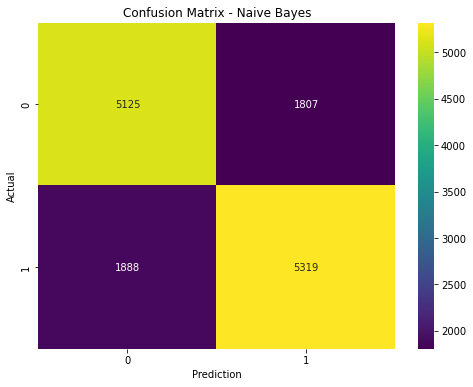

In [43]:
# heatmap matrix
plt.figure(figsize = (8,6))
sns.heatmap(matrix_nb, annot = True, fmt = ".0f", cmap = 'viridis')
plt.title("Confusion Matrix - Naive Bayes")
plt.xlabel("Prediction")
plt.ylabel("Actual")
plt.show()

In [44]:
# NB classification report
report_nb = metrics.classification_report(y_test, y_pred)
print(report_nb)


              precision    recall  f1-score   support

         0.0       0.73      0.74      0.74      6932
         1.0       0.75      0.74      0.74      7207

    accuracy                           0.74     14139
   macro avg       0.74      0.74      0.74     14139
weighted avg       0.74      0.74      0.74     14139



Naive Bayes yields a pretty good result. The recall value is 74%, which is pretty good.
Now I will evaluate the model using Stratified K-Fold Cross Validation with 10 folds.

In [45]:
from sklearn.model_selection import cross_val_score

In [46]:
# cross validate
scores_nb = cross_val_score(cnb, X, y, cv=10)
print(scores_nb)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores_nb.mean(), scores_nb.std()))

[0.72545969 0.72602546 0.73786957 0.73192814 0.73376715 0.72867449
 0.74451832 0.7392842  0.73900127 0.7464988 ]
0.74 accuracy with a standard deviation of 0.01


This model performs pretty well across the entire data.

### 2. Decision Tree


By translating data into a tree representation, Decision Tree is a good algorithm for classification. Each attribute is represented by an internal node in the tree, and each class label is represented by a leaf node. 
I want to try Decision Tree because it can work well with both categorical and numerical data. It also requires very little preprocessing, so there is no need for scaling, normalization, one-hot encoding, etc. The only downside is that since my data has many features, I will have to choose a proper depth limit so that the tree will not be to large and the algorithm won't take too long to execute.

In [47]:
from sklearn import tree

In [48]:
# drop target from X and save the target to y
X = data.drop('Diabetes_binary', axis = 1)
y = data['Diabetes_binary']
# split data into test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [49]:
# create Decision Tree classifer object
dt = tree.DecisionTreeClassifier(max_depth=5)
# train Decision Tree Classifer
%time dt = dt.fit(X_train,y_train)
# get the results
y_pred = dt.predict(X_test)

CPU times: user 122 ms, sys: 1.85 ms, total: 123 ms
Wall time: 150 ms


[Text(0.5, 0.9166666666666666, 'HighBP <= 0.5\ngini = 0.5\nsamples = 56553\nvalue = [28414, 28139]'),
 Text(0.25, 0.75, 'GenHlth <= 2.5\ngini = 0.405\nsamples = 24714\nvalue = [17732, 6982]'),
 Text(0.125, 0.5833333333333334, 'Age <= 8.5\ngini = 0.246\nsamples = 13897\nvalue = [11898, 1999]'),
 Text(0.0625, 0.4166666666666667, 'BMI <= 28.5\ngini = 0.163\nsamples = 8760\nvalue = [7977, 783]'),
 Text(0.03125, 0.25, 'HighChol <= 0.5\ngini = 0.107\nsamples = 6234\nvalue = [5882, 352]'),
 Text(0.015625, 0.08333333333333333, 'gini = 0.077\nsamples = 5022\nvalue = [4820, 202]'),
 Text(0.046875, 0.08333333333333333, 'gini = 0.217\nsamples = 1212\nvalue = [1062, 150]'),
 Text(0.09375, 0.25, 'Age <= 6.5\ngini = 0.283\nsamples = 2526\nvalue = [2095, 431]'),
 Text(0.078125, 0.08333333333333333, 'gini = 0.205\nsamples = 1596\nvalue = [1411, 185]'),
 Text(0.109375, 0.08333333333333333, 'gini = 0.389\nsamples = 930\nvalue = [684, 246]'),
 Text(0.1875, 0.4166666666666667, 'BMI <= 27.5\ngini = 0.361\ns

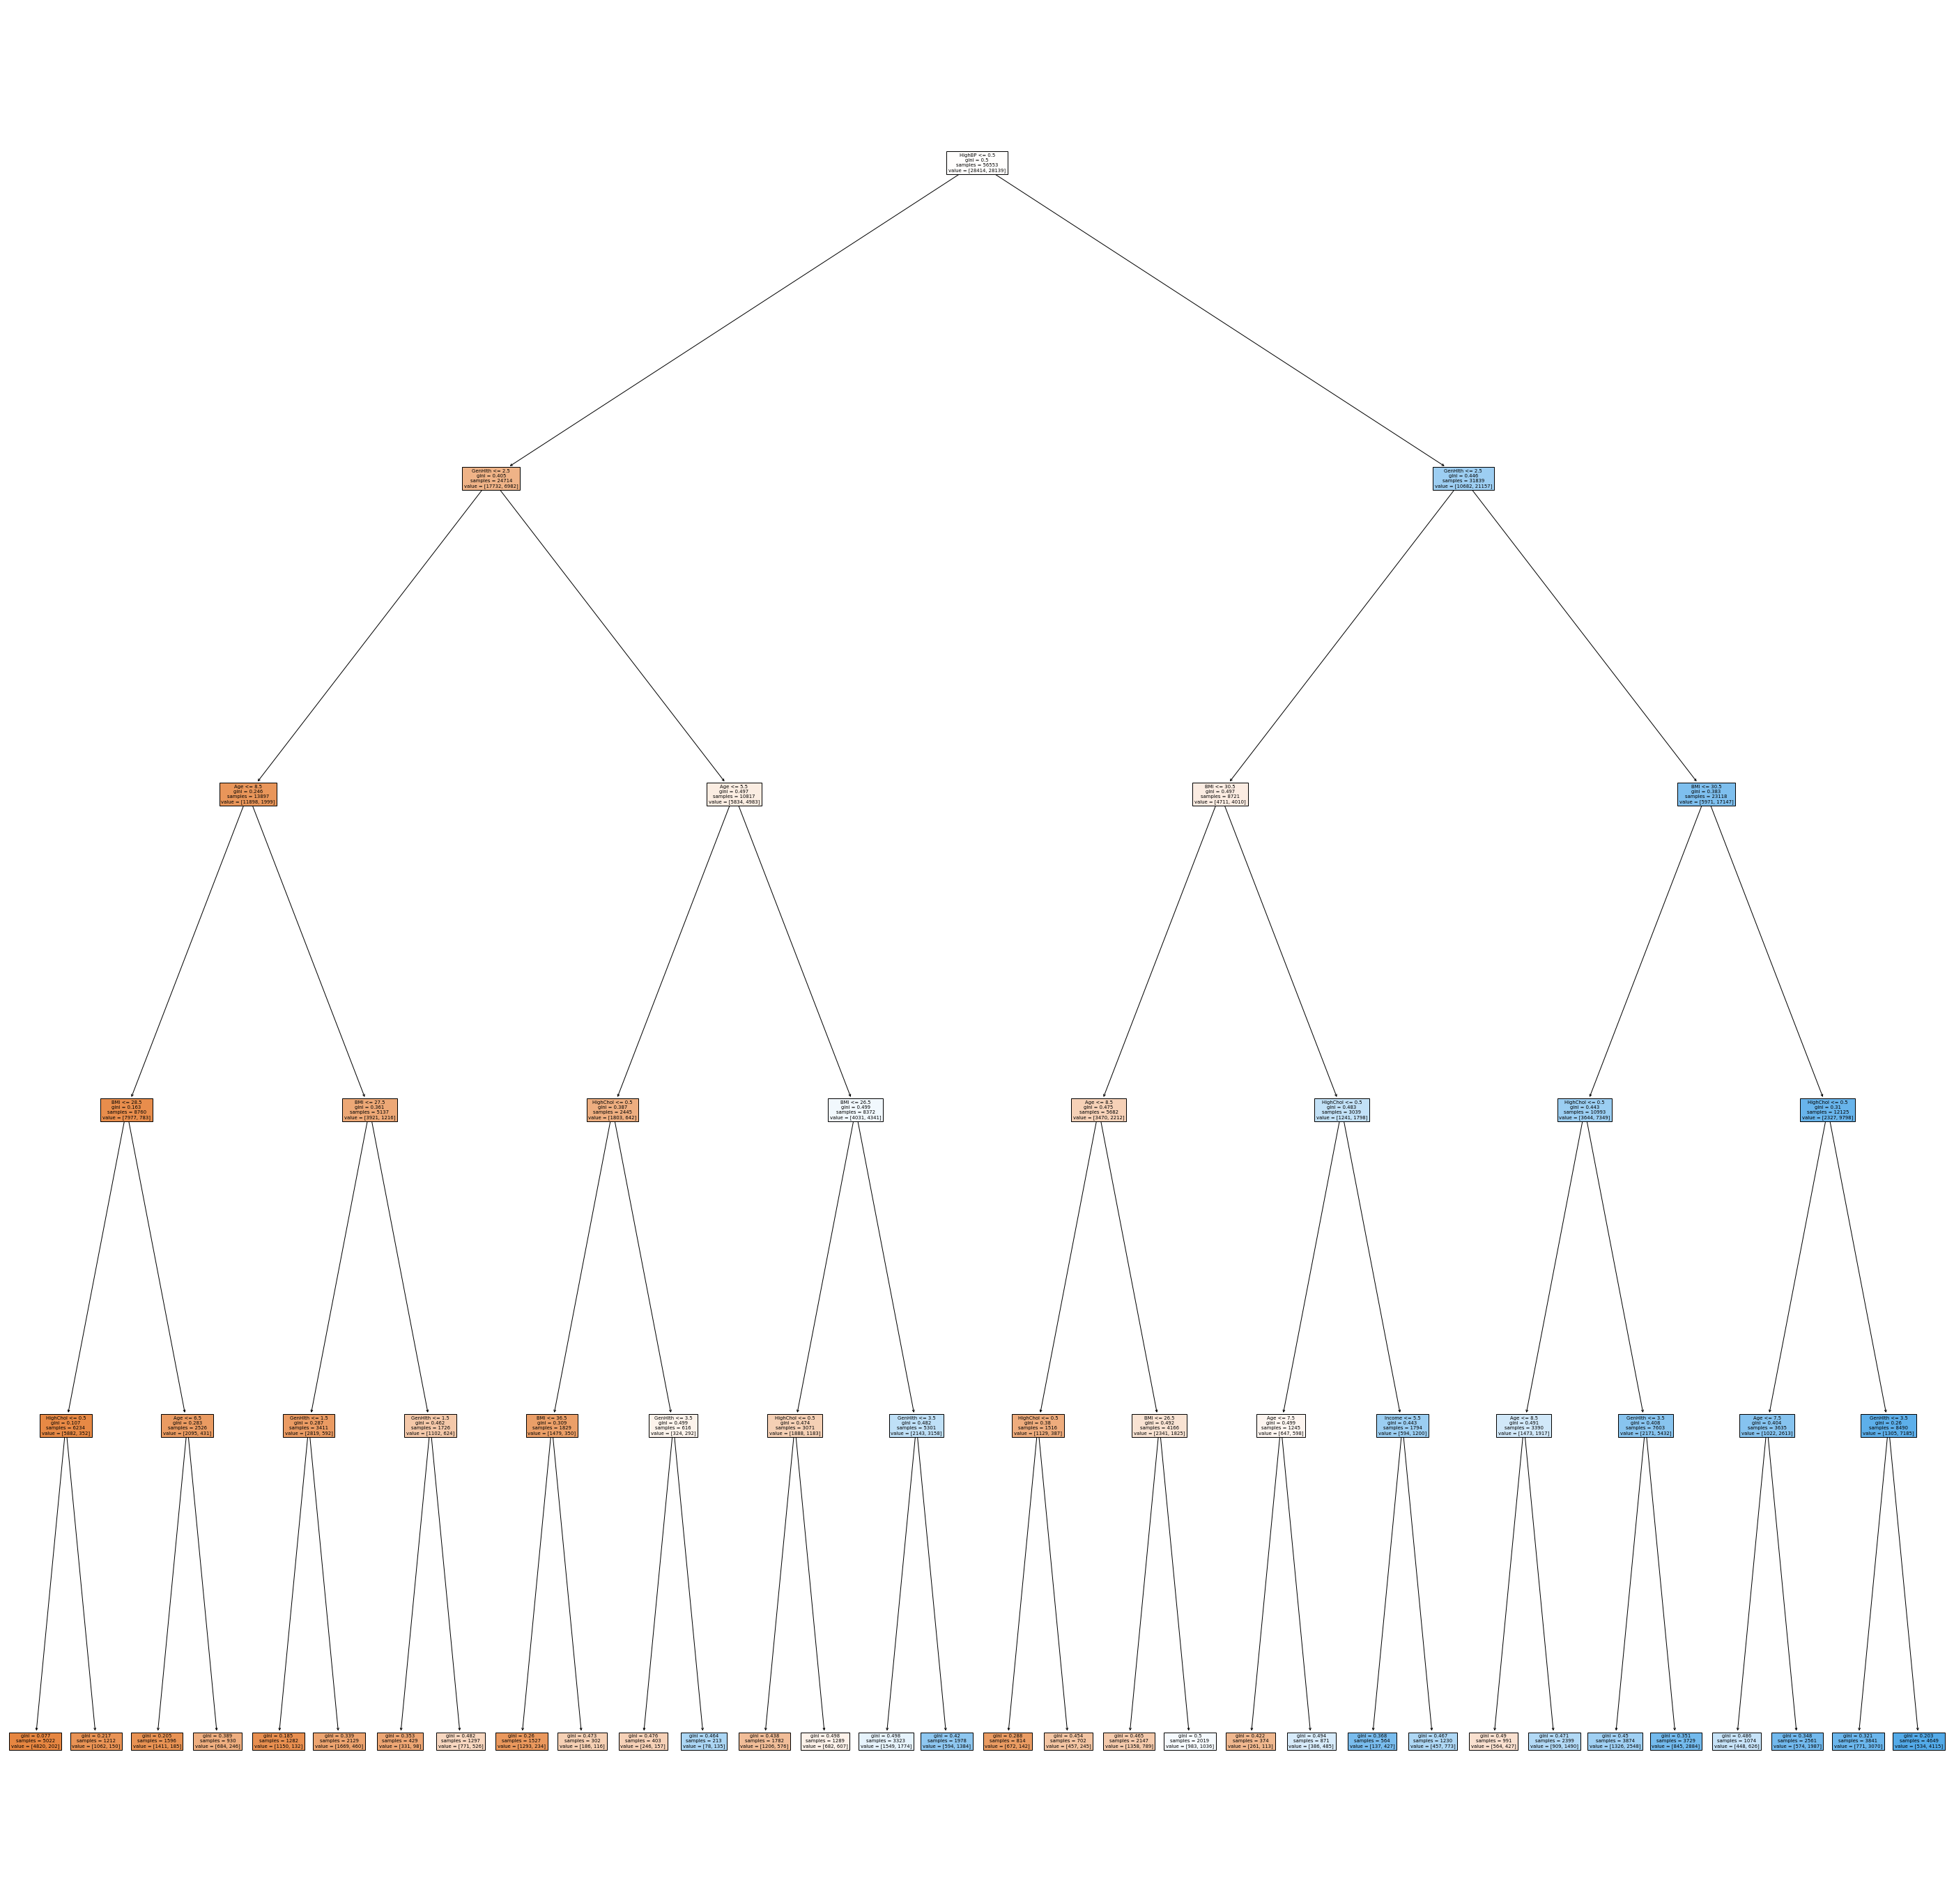

In [50]:
# get names of all features
feature_names = ['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Stroke',
       'HeartDiseaseorAttack', 'PhysActivity', 'GenHlth', 'MentHlth',
       'PhysHlth', 'DiffWalk', 'Age', 'Education', 'Income']
# plot tree
plt.figure(figsize=(50,50))
tree.plot_tree(dt, feature_names=feature_names, filled=True)

In [51]:
# confusion matrix to evaluate model
matrix_dt = metrics.confusion_matrix(y_test, y_pred)
print(matrix_dt)

[[4540 2392]
 [1385 5822]]


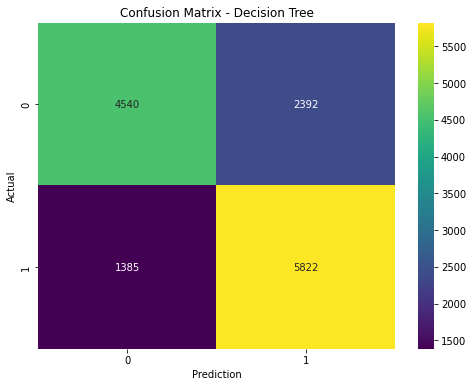

In [52]:
# heatmap matrix
plt.figure(figsize = (8,6))
sns.heatmap(matrix_dt, annot = True, fmt = ".0f", cmap = 'viridis')
plt.title("Confusion Matrix - Decision Tree")
plt.xlabel("Prediction")
plt.ylabel("Actual")
plt.show()

In [53]:
# RF classification report
report_dt = metrics.classification_report(y_test, y_pred)
print(report_dt)


              precision    recall  f1-score   support

         0.0       0.77      0.65      0.71      6932
         1.0       0.71      0.81      0.76      7207

    accuracy                           0.73     14139
   macro avg       0.74      0.73      0.73     14139
weighted avg       0.74      0.73      0.73     14139



In [54]:
# cross validate
scores_dt = cross_val_score(dt, X, y, cv=10)
print(scores_dt)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores_dt.mean(), scores_dt.std()))

[0.72574257 0.72347949 0.72697694 0.72867449 0.73291838 0.7309379
 0.74013297 0.73985005 0.73362569 0.74296223]
0.73 accuracy with a standard deviation of 0.01


For a depth of 5, the Decision Tree is able to give good results. Increasing the depth limit would definitely make it perform better on training data, but it also makes it more prone to overfitting.

### 3. Random Forest



Random Forest is an ensemble method for classification using multiple decision trees. I am going to use Random Forest because it is useful for application where accuracy matters and it is suitable for large data sets. It is good for both discrete and continuous variables. Preprocessing is also quite easy. Since Decision Tree Classifier gave a pretty good result, I want to take a step further and try Random Forest to see if it will yield better results. 

In [55]:
# drop target from X and save the target to y
X = data.drop('Diabetes_binary', axis = 1)
y = data['Diabetes_binary']
# split data into test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [56]:
from sklearn.ensemble import RandomForestClassifier


In [57]:
# build random forest model
rf = RandomForestClassifier(random_state = 1, max_features = 'sqrt', n_jobs = 1, verbose = 1)
# train the model
%time rf.fit(X_train, y_train)
# mean accuracy on test data and labels
rf.score(X_test, y_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    5.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


CPU times: user 5.65 s, sys: 149 ms, total: 5.8 s
Wall time: 5.8 s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished


0.7242379234740788

In [58]:
# get the predictions
y_pred = rf.predict(X_test)
print(y_pred)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[1. 0. 0. ... 1. 0. 1.]


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished


Now I am going to evaluate the model with confusion matrix, accuracy, precision, recall and F1 score.

In [59]:
# confusion matrix to evaluate model
matrix_rf = metrics.confusion_matrix(y_test, y_pred)
print(matrix_rf)

[[4731 2201]
 [1698 5509]]


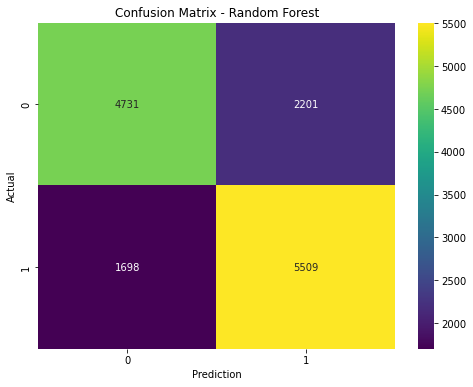

In [60]:
# heatmap matrix
plt.figure(figsize = (8,6))
sns.heatmap(matrix_rf, annot = True, fmt = ".0f", cmap = 'viridis')
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Prediction")
plt.ylabel("Actual")
plt.show()

In [61]:
# RF classification report
report_rf = metrics.classification_report(y_test, y_pred)
print(report_rf)


              precision    recall  f1-score   support

         0.0       0.74      0.68      0.71      6932
         1.0       0.71      0.76      0.74      7207

    accuracy                           0.72     14139
   macro avg       0.73      0.72      0.72     14139
weighted avg       0.72      0.72      0.72     14139



In [62]:
# cross validate
scores_rf = cross_val_score(rf, X, y, cv=10)
print(scores_rf)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores_rf.mean(), scores_rf.std()))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    6.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    6.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    6.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[0.72319661 0.71711457 0.72655255 0.71608431 0.7271184  0.72839157
 0.73390862 0.72358184 0.72527939 0.73730372]
0.73 accuracy with a standard deviation of 0.01


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished


Although this model performs pretty well across the entire data, it is not better than Naive Bayes or Decision Tree, which is a bit surprising. 

Overall: Interestingly, Naive Bayes produced the best results out of 3 models. This might be because Naive Bayes is resilient to noisy data. It is also the fastest out of 3 models, with only a bit over 50 ms! Decision Trees and Random Forest have similar performance, which is surprising because I expected Random Forest to have better results. Perhaps I need to reduce the number of irrelevant features and try some techniques to see if these 2 models can improve, since I think they should be able to yield better results. 

## Conclusion

Through this entire process, I was able to learn so much about data preprocessing, modeling, and evaluating results. It was very challenging to figure out what is the best method to treat the data and choosing the right model for the data set. I definitely see how difficult it can be to optimize the performance of the models to yield the best results when having to work with a relatively big and complicated dataset with a mix of categorical and numerical features like this diabetes data set. I am glad to take on this challenge because I was able to understand more about the importance of Feature Selection, some preprocessing techniques such as One Hot Encoding and Target Encoding, how different machine learning models work for classification tasks, how to evaluate the model performance and deciding what to do from there to improve the models' performance. 